In [1]:
%matplotlib inline

import sys
import os

import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import Normalize
from skimage import exposure, img_as_float, morphology
from PIL import Image

from osgeo import gdal
import osr
import xml.etree.ElementTree as ET
from my_packages.My_Geoprocess import*

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics

from sklearn.cluster import KMeans

# A list of "random" colors (for a nicer output)
COLORS = ["#FFFF00", "#008000", "#ff4a46",   "#FF34FF", "#1CE6FF", "#008941"]

In [3]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols),dtype=np.int8)
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1).ReadAsArray()
        index = np.logical_and(band!=0, labeled_pixels!=0)
        labeled_pixels += band
        labeled_pixels[index] = 0
        ds = None
        #print(np.unique(band),'global :',np.unique(labeled_pixels))
    return labeled_pixels

In [4]:
###          Functions :  
# ------------------------------------------------------------------------
##     Helper functions
    
# load csv  
def load_train_csv(data_path, sub_sample=False):
    """Loads data and returns HeaderName (Name Column), X (features) and ids (labels)"""
    HeaderName = np.genfromtxt(data_path, delimiter=",", dtype=str, max_rows=1)
    inputData = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    
    ids = inputData[:, :4].astype(np.int)
    X = inputData[:, 4:]
    
    # sub-sample
    if sub_sample:
        X = X[::50]
        ids = ids[::50]

    return HeaderName, ids, X

def load_tree_csv(data_path, sub_sample=False):
    """Loads data and returns HeaderName (Name Column), X (features) and ids (labels)"""
    HeaderName = np.genfromtxt(data_path, delimiter=",", dtype=str, max_rows=1)
    inputData = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    
    ID = inputData[:, 0].astype(np.int)
    CX = inputData[:, 1]
    CY = inputData[:, 2]
    
    return ID, CX, CY

# load image
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w1, w2, h1, h2):
    return im[h1:h2+1, w1: w2+1]

def ismember(A,B, KeepOccur=False):
    '''Return logical index of element position of array A in B'''
    test=np.asarray([a==B for a in A])
    if not KeepOccur:
        return np.sum(test,axis=0)>0
    else:
        return np.sum(test,axis=0)

# ------------------------------------------------------------------------
##     Functions used for extraction of features

# Improve dimensionality of dataset
def Features_Product(a):
    '''Return the product features'''
    # Compute full matrix
    Column_Repet=np.array([np.tile(a[:,c],(a.shape[1],1)) for c in range(a.shape[1])]).reshape(a.shape[1]**2,a.shape[0]).T
    Brut_Product = np.multiply(Column_Repet,np.tile(a, (1,a.shape[1]))).T
    # Filter unique columns
    b = np.ascontiguousarray(Brut_Product).view(np.dtype((np.void, Brut_Product.dtype.itemsize * Brut_Product.shape[1])))
    Unique_Product = np.unique(b).view(Brut_Product.dtype).reshape(-1, Brut_Product.shape[1]).T
    return Unique_Product

def Features_Ratio(a):
    n = a.shape[1]
    
    Column_Repet=np.array([np.tile(a[:,c],(a.shape[1],1)) for c in range(a.shape[1])]).reshape(a.shape[1]**2,a.shape[0]).T
    Brut_ratio= np.divide(Column_Repet,np.tile(a, (1,a.shape[1])))
    
    index = ind=np.arange(n) + np.arange(n)*n
    keep = ~ismember(ind, np.arange(n**2))
    Clean_ratio=Brut_ratio[:,keep]
    
    
    
    keep =~(np.sum(np.isinf(Clean_ratio),axis=0)>0)
    Clean_ratio=Clean_ratio[:,keep]
    
    
    keep =~(np.sum(np.isnan(Clean_ratio),axis=0)>0)
    Clean_ratio = Clean_ratio[:,keep]
    
    return Clean_ratio

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_segs = quickshift(img,ratio=1, convert2lab='False')
    
    Specific_Seg = []
    for i in np.unique(img_segs):
        Temp = np.array(img)
        Temp[img_segs != i, :] =np.NAN
        Temp = Temp[np.sum(np.isnan(Temp[:,:,0]), axis=1)!=Temp.shape[1],:,:]
        Temp = Temp[:,np.sum(np.isnan(Temp[:,:,0]), axis=0)!=Temp.shape[0],:]
        Specific_Seg.append(Temp)
        del Temp
        
    X = np.asarray([ extract_features(Specific_Seg[i]) for i in range(len(Specific_Seg))])
    return X, img_segs, img

# ------------------------------------------------------------------------
##     Functions used for label assigntion
    
# Assign a groundtruth label for each segment
def value_to_seg(v,Thres):
    df = np.mean(v)
    if df > Thres:
        return 1
    else:
        return 0
    
# ------------------------------------------------------------------------
##     Functions used for model and cross-validation
    
# Split the dataset in testset(X_test,Y_test) and trainset(X,Y)
def my_split_data(x, y, ratio, seed=None):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    ind = np.random.permutation(x.shape[0])
    x,y = x[ind], y[ind]
    NumberOfTrained = int(np.floor(ratio * x.shape[0]))
    x_train = x[:NumberOfTrained]
    y_train = y[:NumberOfTrained]
    x_test = x[NumberOfTrained:]
    y_test = y[NumberOfTrained:]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    return x_train, y_train, x_test, y_test

def SplitandBalancedata(x, y, ratio, myseed=None):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, y_tr, x_te, y_tr, y_te

def build_k_StratIndices(y, Balance, seed=None):
    """build k indices for k-fold."""
    # set seed
    np.random.seed(myseed)
    # set parameter
    uid = np.unique(y)
    Cumul = np.asarray([np.int(np.sum(y==uid[i])) for i in range(uid.shape[0])])
    k_fold = np.floor(np.max(Cumul)/Balance)
    Fractions = np.floor(Cumul/k_fold)
    Multiplicateur =  np.max(Fractions) / Fractions
    # initialize
    Y = [ np.asarray([k for k, l in enumerate(y) if l == uid[j] ]) for j in range(uid.shape[0])]
    Y2 = Y[:][:]
    Y2 = [  np.random.permutation(Y2[i]).T for i in range(uid.shape[0]) ]
    k_indices = [ [[] for i in range(uid.shape[0])] for k in range(k_fold) ]
    # loop
    for k in range(k_fold):
        for i in range(uid.shape[0]):
            if len(Y2[i][:]) - 10 < 0:
                Y2[i] = np.append(Y2[i][:], \
                  np.random.permutation(Y[i][~ismember(Y2[i][:],Y[i][:])]))
            
            k_indices[k][i] = Y2[i][:Balance]
            Y2[i]= Y2[i][ ~ismember(k_indices[k][i],Y2[i][:])]
    # formate        
    K_indices = [np.reshape(k_indices[i], (uid.shape[0]*Balance,1)) for i in range(uid.shape[0])]
    return K_indices, Multiplicateur

def CV_F1_TPR(model,X ,Y, k_indices, k):
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = Y[te_indice]
    y_tr = Y[tr_indice]
    x_te = X[te_indice]
    x_tr = X[tr_indice]
    
    # train model
    model.fit(x_tr, y_tr)
    
    # form data with polynomial degree
    # Predict on the training set
    Z_test = model.predict(x_te)
    Z_train = model.predict(x_tr)
    # Get non-zeros in prediction and grountruth arrays
    Z_testn = np.nonzero(Z_test)[0]
    Z_trainn = np.nonzero(Z_train)[0]
    Y_testn = np.nonzero(y_te)[0]
    Y_trainn = np.nonzero(y_tr)[0]
    
    # Compute scores
    TPR_testc = len(list(set(Y_testn) & set(Z_testn))) / float(len(Y_testn))
    score_testc = metrics.f1_score(y_te,Z_test)

    TPR_trainc = len(list(set(Y_trainn) & set(Z_trainn))) / float(len(Y_trainn))
    score_trainc = metrics.f1_score(y_tr,Z_train)
    return score_trainc, score_testc, TPR_trainc, TPR_testc
# ------------------------------------------------------------------------
##     Functions of visualisation
    
# 
def result_vis(C, score_test, score_train, TPR_test, TPR_train, usePca, balance):
    plt.semilogx(C, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
    plt.semilogx(C, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
    plt.semilogx(C, np.asarray(TPR_train), marker=".",linestyle="--", color='b', label='train True P.R.')
    plt.semilogx(C, np.asarray(TPR_test), marker=".",linestyle="--", color='r', label='test True P.R.')
    plt.xlabel("Lambda")
    plt.ylabel("Score")
    if usePca and balance:
        plt.title("cross validation: svmRBF, features: reduced, class: balanced")
    elif usePca and balance ==0:
        plt.title("cross validation: LinearSVC, features: reduced")
    elif usePca==0 and balance :
        plt.title("cross validation: svmRBF, class: balanced")
    elif usePca ==0 and balance ==0:
        plt.title("cross validation: LinearSVC")
    plt.legend(loc=0)
    plt.grid(True)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
# ------------------------------------------------------------------------
##     Functions of converstion to submission

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images_test(gt_img):
    nChannels = len(gt_img.shape)
    
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    
    if nChannels == 3:
        cimg = gt_img
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        cimg = gt_img_3c
    return cimg

# Display prediction as an image
def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def label_to_img(img_segments, Zi):
    im = np.array(img_segments)
    for i,j in enumerate(np.unique(img_segments)):
        im[img_segments==j] = Zi[i]
    return im

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/
    human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]




In [6]:
rasters_data_path = "D:/Image/processed/S2A_OPER_PRD_MSIL1C_PDMC_20161101T012450_R101_V20161031T230902_20161031T230902.SAFE/GRANULE/S2A_OPER_MSI_L1C_TL_MPS__20161101T001337_A007105_T58KFA_N02.04/Deglinted/Valid/"
raster_data_path = [f for f in os.listdir(rasters_data_path) if f.endswith('.tif')]

bands_data = []
for f in range(len(raster_data_path)):
    raster_dataset = gdal.Open(rasters_data_path+raster_data_path[f], gdal.GA_ReadOnly)
    for b in range(1, raster_dataset.RasterCount+1):
        band = raster_dataset.GetRasterBand(b)
        bands_data.append(band.ReadAsArray())
        
for i in range(len(bands_data)):
    print(bands_data[i].shape)
bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape
print(bands_data.shape)

raster_dataset = gdal.Open(rasters_data_path+raster_data_path[0], gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
del raster_dataset

(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980)
(10980, 10980, 5)


# Compute descriptors : 

In [7]:
train_data_path = "C:/Users/samrari/ComputBuffer/Classif/Classif_Eclatee/"
FilePath = 'D:/Image/processed/S2A_OPER_PRD_MSIL1C_PDMC_20161101T012450_R101_V20161031T230902_20161031T230902.SAFE/'

files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]
labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)

SoilMask = gdal.Open( FilePath+'/Mask/'+'10m.tif')
SoilIndex = SoilMask.GetRasterBand(1).ReadAsArray().astype(np.bool_)
del SoilMask

print('Number of survey above ground surface: ',np.sum(labeled_pixels[SoilIndex]!=0))
labeled_pixels[SoilIndex] = 0
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]
print('Number of survey : ', training_samples.shape[0])

Number of survey above ground surface:  0
Number of survey :  1190


percentiles  6 ,  94  of band  0 :  395.0 ,  1843.0 

percentiles  6 ,  94  of band  1 :  607.0 ,  1896.0 

percentiles  6 ,  94  of band  2 :  779.0 ,  2059.0 



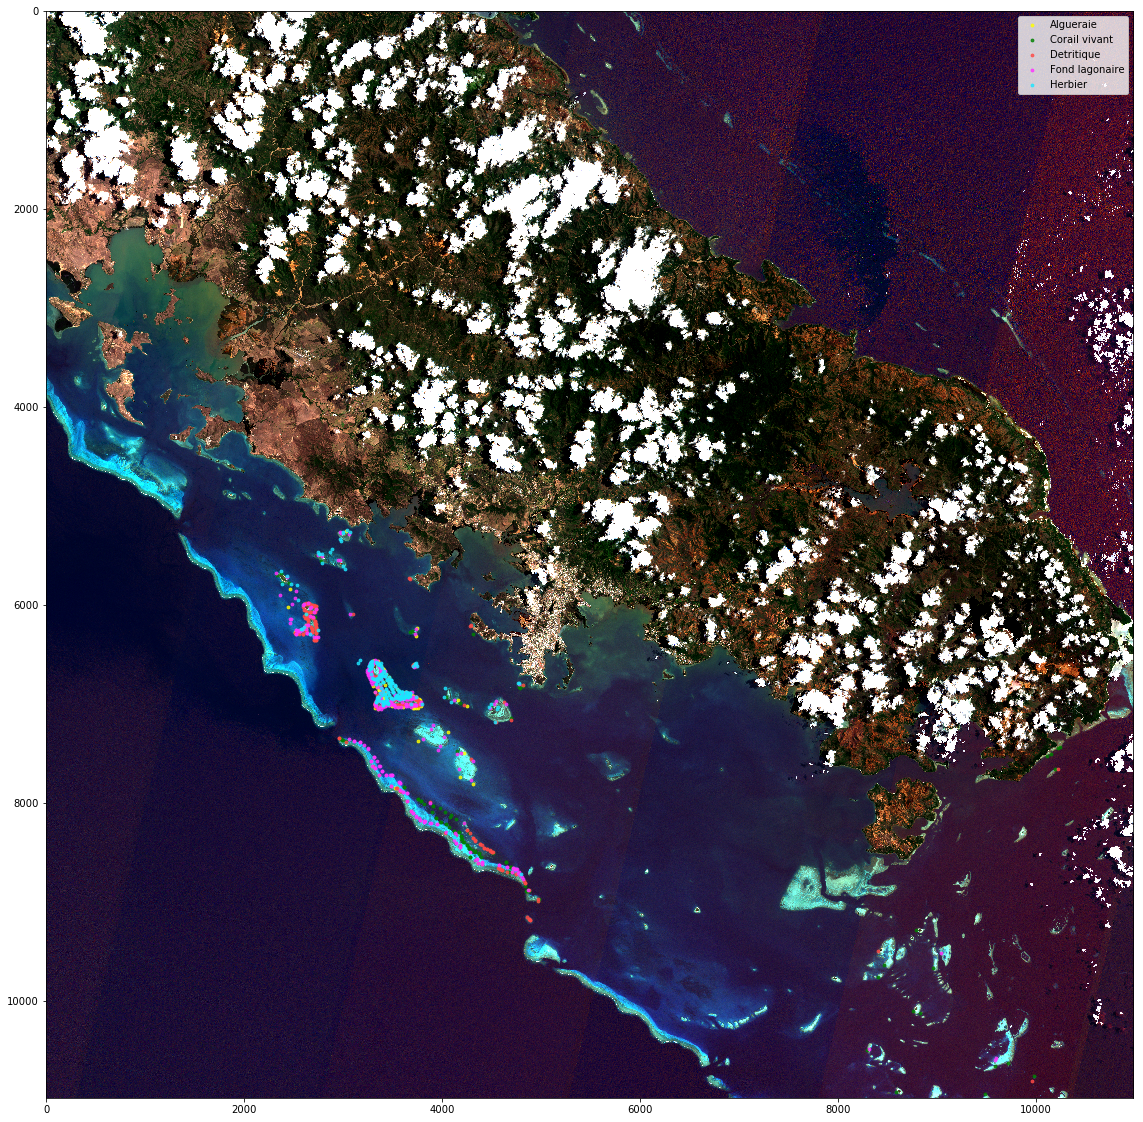

In [6]:
better_contrast = np.empty((bands_data.shape[0],bands_data.shape[1], 3), dtype= bands_data.dtype)
p_min = 6
p_max = 94
for i in range(3):
    v_min, v_max = np.percentile(bands_data[:,:,i], (p_min, p_max))
    print('percentiles ',p_min,', ',p_max,' of band ',str(i),': ',str(v_min),', ',str(v_max),'\n')
    better_contrast[:,:,i] = exposure.rescale_intensity(bands_data[:,:,i], in_range=(v_min, v_max))

fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(img_as_float(better_contrast))
row, column = np.unravel_index(is_train, labeled_pixels.shape)
for i in np.unique(training_labels):
    index = training_labels==i
    ax.scatter(is_train[1][index],is_train[0][index],alpha=0.8, s=8, c=COLORS[i-1], label=classes[i-1])
ax.legend()

In [6]:
HeaderName, ids, X = classes, training_labels,training_samples
print("Header: \n")
print(HeaderName)
print("Data: \n")
print(X)
print("Labels: \n")
print(ids)
print("shape: \n")

Header: 

['Algueraie', 'Corail vivant', 'Detritique', 'Fond lagonaire', 'Herbier']
Data: 

[[ 536  801 1121 1476  527]
 [ 606 1295 1518 1643  541]
 [ 582 1213 1449 1595  515]
 ..., 
 [ 682  880 1243 1498  612]
 [ 796  941 1416 1613  637]
 [ 743  927 1255 1575  686]]
Labels: 

[5 1 5 ..., 3 2 2]
shape: 



In [ ]:
ids.shape[1]

# Check Dimensionality

In [7]:
# Print feature statistics
NClasse = np.max(ids, axis=0)

tY = ids
tX = X
#tY = ids[:,Label_choosen]

# Print feature statistics
print('Recorded ' + str(tX.shape[0]) + ' surveys')
print('Feature dimension = ' + str(X.shape[1]))
print('Numbers of classes = ' + str(NClasse))

YC = [ [l for l in ids if l == j] for j in range(1,NClasse+1)]
for j in range(1,NClasse+1):
    print('LabelType :' + str(HeaderName[j-1]) + ', Class '+ str(j) + ': ' + str(len(YC[j-1])) + ' samples')
print("\n")



Recorded 1190 surveys
Feature dimension = 5
Numbers of classes = 5
LabelType :Algueraie, Class 1: 126 samples
LabelType :Corail vivant, Class 2: 151 samples
LabelType :Detritique, Class 3: 282 samples
LabelType :Fond lagonaire, Class 4: 387 samples
LabelType :Herbier, Class 5: 244 samples




# Perform features Muliplication

In [8]:
tX = np.hstack((tX,Features_Product(tX),Features_Ratio(tX)))
scaler2 = preprocessing.StandardScaler().fit(tX)
tX = np.array(scaler2.transform(tX))

tX.shape

(1190, 40)

# Perform features reduction by PCA

In [9]:
# Perform pca and scale data

scaler = preprocessing.StandardScaler().fit(tX)
tX = scaler.transform(tX)
usePca = 1
mod = '99'
VarKeeped = 99.99 # Variance keeped in percent %
if usePca:
    print(tX.shape[1])
    pca = PCA()
    tX_reduced = pca.fit(tX).transform(tX)
    numberOfFeatures = np.sum(VarKeeped>np.cumsum((pca.explained_variance_ratio_)*100))

    print('Number Principal Component : ',numberOfFeatures), print('for', str(VarKeeped),'percent of variance keeped\n')
    print(VarKeeped>np.cumsum((pca.explained_variance_ratio_)*100))
    if mod == 'Full':
        tX = np.array(tX_reduced[:,:])
    else:
        tX = np.array(tX_reduced[:,0:numberOfFeatures])
    print(tX_reduced.shape)
    print(tX.shape)
else:
    tX = np.array(scaler.transform(tX))
    
scaler.mean_.shape
tX.shape

40
Number Principal Component :  27
for 99.99 percent of variance keeped

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False]
(1190, 40)
(1190, 27)


(1190, 27)

In [ ]:
print(pca)

# Perform Cross-validation
# Kernel Linear

C = exp(-3.00)
C = exp(-1.69)
C = exp(-0.38)
C = exp(0.93)
C = exp(2.24)
C = exp(3.55)
C = exp(4.86)
C = exp(6.17)
C = exp(7.48)
C = exp(8.79)
C = exp(10.10)
C = exp(11.41)
C = exp(12.72)
C = exp(14.03)
C = exp(15.34)
C = exp(16.66)
C = exp(17.97)
C = exp(19.28)
C = exp(20.59)
C = exp(21.90)
C = exp(23.21)
C = exp(24.52)
C = exp(25.83)
C = exp(27.14)
C = exp(28.45)
C = exp(29.76)
C = exp(31.07)
C = exp(32.38)
C = exp(33.69)
C = exp(35.00)
0.344936888236


0.34493688823631391

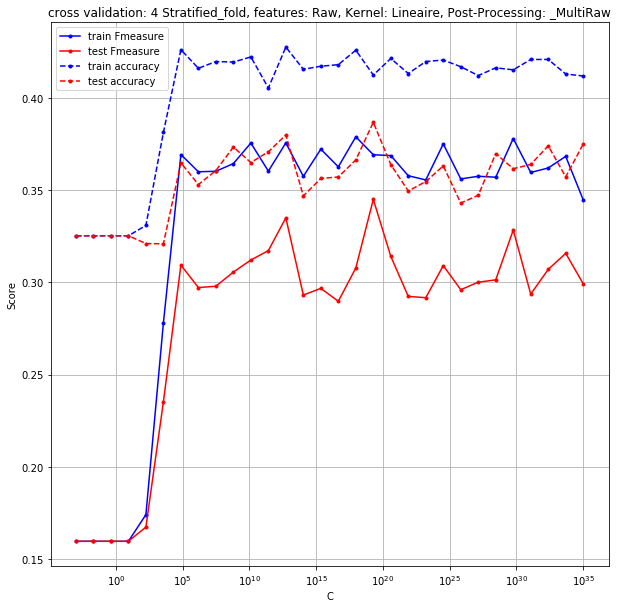

In [33]:
import warnings
warnings.filterwarnings('ignore')

C_range = np.logspace(-3,35,num= 30)

K_fold = 4
Acc_test = []
score_test = []
Acc_train = []
score_train = []

# Initialize folder
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
skf.get_n_splits(tX, tY)

for c in C_range:   
    
    print("C = exp(%.2f)"%(np.log10(c)))

    Acc_te_tmp = []
    score_te_tmp = []
    Acc_tr_tmp = []
    score_tr_tmp = []

    for train_index, test_index in skf.split(tX, tY):

        # get k'th subgroup in test, others in train
        x_te, y_te = tX[test_index], tY[test_index]
        x_tr, y_tr = tX[train_index], tY[train_index]

        # Stritified factor correction
        uid = np.unique(y_tr)
        Cumul = np.asarray([np.int(np.sum(y_tr==uid[i])) for i in range(uid.shape[0])])
        tot = np.sum(Cumul)
        weight = {uid[i]: (Cumul[i]/tot) for i in range(uid.shape[0])}
        weightN = np.asarray([(Cumul[k]/tot) for k in range(uid.shape[0]) for j in y_tr if j==uid[k]])

        # Model initilization
        model = svm.SVC( decision_function_shape='ovo', kernel='linear', C=c,\
                         max_iter=10000, tol=1e-6)
        #model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)

        # Model training
        model.fit(x_tr, y_tr, sample_weight=weightN)

        # Predict on the training and test set
        Z_test = model.predict(x_te)
        Z_train = model.predict(x_tr)

        # Metrics computation
        # --- Teste scores
        Acc_te_tmp.append(metrics.accuracy_score(y_te,Z_test))
        score_te_tmp.append(metrics.f1_score(y_te,Z_test, average='weighted'))
        # --- Train scores
        Acc_tr_tmp.append(metrics.accuracy_score(y_tr,Z_train))
        score_tr_tmp.append(metrics.f1_score(y_tr,Z_train, average='weighted'))

    # Metrics computation
    # --- Teste scores
    Acc_test.append(np.mean(Acc_te_tmp))
    score_test.append(np.mean(score_te_tmp))
    # --- Train scores
    Acc_train.append(np.mean(Acc_tr_tmp))
    score_train.append(np.mean(score_tr_tmp))

print(np.max(score_test))
# PCA 100% : 0.66981776119574399
# PCA 100% -> multiplicateur : 0.19
# multiplicateur -> PCA 100%: 0.63241400478822141
# PCA 100% est mieux que PCA Full
SpecPP = "_MultiRaw" # To be change !!!
plt.figure(figsize=(10, 10))
plt.semilogx(C_range, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
plt.semilogx(C_range, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
plt.semilogx(C_range, np.asarray(Acc_train), marker=".",linestyle="--", color='b', label='train accuracy')
plt.semilogx(C_range, np.asarray(Acc_test), marker=".",linestyle="--", color='r', label='test accuracy')
plt.xlabel("C")
plt.ylabel("Score")
plt.title("cross validation: 4 Stratified_fold, features: Raw, Kernel: Lineaire, Post-Processing: "+SpecPP)
plt.legend(loc=0)
plt.grid(True)
np.max(score_test)

In [ ]:
SpecPP = "_MultiRaw" # To be change !!!
plt.figure(figsize=(10, 10))
plt.semilogx(C_range, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
plt.semilogx(C_range, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
plt.semilogx(C_range, np.asarray(Acc_train), marker=".",linestyle="--", color='b', label='train accuracy')
plt.semilogx(C_range, np.asarray(Acc_test), marker=".",linestyle="--", color='r', label='test accuracy')
plt.xlabel("C")
plt.ylabel("Score")
plt.title("cross validation: 4 Stratified_fold, features: Raw, Kernel: Lineaire, Post-Processing: "+SpecPP)
plt.legend(loc=0)
plt.grid(True)
np.max(score_test)
plt.savefig("figures/Raw/Lineaire"+SpecPP) 
MaxPos = np.argmax(score_test)

with open('figures/Raw/Results.txt', 'a') as mon_fichier:
    mon_fichier.write('\n')
    mon_fichier.write('\n')
    mon_fichier.write('--------------------------------------------------------------------------')
    mon_fichier.write('\n')
    print('-----> PostProcessing : ',SpecPP, file=mon_fichier)
    mon_fichier.write(str(model))
    mon_fichier.write('\n')
    print('Best Fmeasure:', str(score_test[MaxPos]),', -> accuracy: ', str(Acc_test[MaxPos]), file=mon_fichier)
    mon_fichier.write('--------------------------------------------------------------------------')
             

# # Kernel : RBF

In [ ]:
import warnings
warnings.filterwarnings('ignore')

C_range = np.logspace(-4,3,num= 20)
gamma_range = np.logspace(-10, 5, num=20)
K_fold = 4
Acc_test = []
score_test = []
Acc_train = []
score_train = []

# Initialize folder
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
skf.get_n_splits(tX, tY)

for c in C_range:  
    
    print("C = %.2f"%c)
    for g in gamma_range:
    
        print("Gamma = exp(%.2f)"%(np.log10(g)))
        Acc_te_tmp = []
        score_te_tmp = []
        Acc_tr_tmp = []
        score_tr_tmp = []

        for train_index, test_index in skf.split(tX, tY):
            
            # get k'th subgroup in test, others in train
            x_te, y_te = tX[test_index], tY[test_index]
            x_tr, y_tr = tX[train_index], tY[train_index]
            
            # Stritified factor correction
            uid = np.unique(y_tr)
            Cumul = np.asarray([np.int(np.sum(y_tr==uid[i])) for i in range(uid.shape[0])])
            tot = np.sum(Cumul)
            weight = {uid[i]: (Cumul[i]/tot) for i in range(uid.shape[0])}
            weightN = np.asarray([100*(Cumul[k]/tot) for k in range(uid.shape[0]) for j in y_tr if j==uid[k]])
            
            # Model initilization
            model = svm.SVC(C=c , decision_function_shape='ovo',cache_size= 10000,  kernel='rbf', gamma=g)
            #model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)

            # Model training
            model.fit(x_tr, y_tr, sample_weight=weightN)

            # Predict on the training and test set
            Z_test = model.predict(x_te)
            Z_train = model.predict(x_tr)

            # Metrics computation
            # --- Teste scores
            Acc_te_tmp.append(metrics.accuracy_score(y_te,Z_test))
            score_te_tmp.append(metrics.f1_score(y_te,Z_test, average='weighted'))
            # --- Train scores
            Acc_tr_tmp.append(metrics.accuracy_score(y_tr,Z_train))
            score_tr_tmp.append(metrics.f1_score(y_tr,Z_train, average='weighted'))
        
        # Metrics computation
        # --- Teste scores
        Acc_test.append(np.mean(Acc_te_tmp))
        score_test.append(np.mean(score_te_tmp))
        # --- Train scores
        Acc_train.append(np.mean(Acc_tr_tmp))
        score_train.append(np.mean(score_tr_tmp))
    print('Mean score Test : {0: 0.2f} with gamma = {1: 0.2f}'\
          .format(np.max(score_test[-len(gamma_range):]), gamma_range[np.argmax(score_test[-len(gamma_range):])]))
        
# Metrics computation
# --- Teste scores        
Acc_test = np.asarray(Acc_test).reshape(len(C_range),len(gamma_range))
score_test = np.asarray(score_test).reshape(len(C_range),len(gamma_range))
# --- Train scores
Acc_train = np.asarray(Acc_train).reshape(len(C_range),len(gamma_range))
score_train = np.asarray(score_train).reshape(len(C_range),len(gamma_range))


# PCA 100% : 0.661386789504
# multiplicateur -> PCA 100%:0.66727337198

SpecPP = "_Multi" # To be change !!!

plt.figure(figsize=(10, 10))
plt.imshow(score_test, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')

plt.figure(figsize=(10, 10))
plt.imshow(Acc_test, interpolation='nearest', cmap='RdBu',
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Accuracy')

print('Maximum F1_score: ', np.max(score_test))
MaxPos = np.argmax(score_test)
CMaxPos = MaxPos//len(gamma_range)
GMaxPos = MaxPos - CMaxPos*len(gamma_range)C
assert(score_test[CMaxPos, GMaxPos] == np.max(score_test))
print('Accuracy following best F_score: ',Acc_test[CMaxPos, GMaxPos])
print(C_range[CMaxPos],gamma_range[GMaxPos])

In [ ]:
len(gamma_range)

In [ ]:
SpecPP = "_Multi" # To be change !!!

plt.figure(figsize=(10, 10))
plt.imshow(score_test, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')
plt.savefig("figures/Raw/F1Kernel"+SpecPP) 

plt.figure(figsize=(10, 10))
plt.imshow(Acc_test, interpolation='nearest', cmap='RdBu',
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Accuracy')
plt.savefig("figures/Raw/AccKernel"+SpecPP) 

# Perform Cross-validation
# RandomForestClassifier

N_estim. = exp(5.00)
N_estim. = exp(6.00)
N_estim. = exp(7.00)
N_estim. = exp(8.00)
N_estim. = exp(9.00)
N_estim. = exp(10.00)
N_estim. = exp(11.00)
N_estim. = exp(12.00)
N_estim. = exp(13.00)
N_estim. = exp(14.00)
N_estim. = exp(15.00)
N_estim. = exp(16.00)
N_estim. = exp(17.00)
N_estim. = exp(18.00)
N_estim. = exp(19.00)
0.311975685623


0.31197568562313149

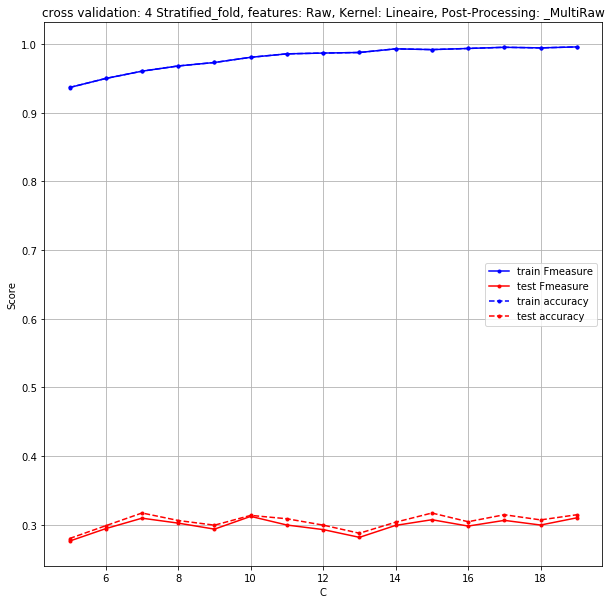

In [21]:

import warnings
warnings.filterwarnings('ignore')
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

n_estimators_range = np.arange(5,20)

K_fold = 4
Acc_test = []
score_test = []
Acc_train = []
score_train = []

# Initialize folder
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
skf.get_n_splits(tX, tY)

for c in n_estimators_range:   
    
    print("N_estim. = exp(%.2f)"%(c))

    Acc_te_tmp = []
    score_te_tmp = []
    Acc_tr_tmp = []
    score_tr_tmp = []

    for train_index, test_index in skf.split(tX, tY):

        # get k'th subgroup in test, others in train
        x_te, y_te = tX[test_index], tY[test_index]
        x_tr, y_tr = tX[train_index], tY[train_index]

        # Stritified factor correction
        uid = np.unique(y_tr)
        Cumul = np.asarray([np.int(np.sum(y_tr==uid[i])) for i in range(uid.shape[0])])
        tot = np.sum(Cumul)
        weight = {uid[i]: (Cumul[i]/tot) for i in range(uid.shape[0])}
        weightN = np.asarray([(Cumul[k]/tot) for k in range(uid.shape[0]) for j in y_tr if j==uid[k]])

        # Model initilization
        model = RandomForestClassifier(n_estimators=c, n_jobs=-1, max_features=None)
        #model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)

        # Model training
        model.fit(x_tr, y_tr, sample_weight=weightN)

        # Predict on the training and test set
        Z_test = model.predict(x_te)
        Z_train = model.predict(x_tr)

        # Metrics computation
        # --- Teste scores
        Acc_te_tmp.append(metrics.accuracy_score(y_te,Z_test))
        score_te_tmp.append(metrics.f1_score(y_te,Z_test, average='weighted'))
        # --- Train scores
        Acc_tr_tmp.append(metrics.accuracy_score(y_tr,Z_train))
        score_tr_tmp.append(metrics.f1_score(y_tr,Z_train, average='weighted'))

    # Metrics computation
    # --- Teste scores
    Acc_test.append(np.mean(Acc_te_tmp))
    score_test.append(np.mean(score_te_tmp))
    # --- Train scores
    Acc_train.append(np.mean(Acc_tr_tmp))
    score_train.append(np.mean(score_tr_tmp))

print(np.max(score_test))
# PCA 100% : 0.66981776119574399
# PCA 100% -> multiplicateur : 0.19
# multiplicateur -> PCA 100%: 0.63241400478822141
# PCA 100% est mieux que PCA Full
SpecPP = "_MultiRaw" # To be change !!!
plt.figure(figsize=(10, 10))
plt.plot(n_estimators_range, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
plt.plot(n_estimators_range, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
plt.plot(n_estimators_range, np.asarray(Acc_train), marker=".",linestyle="--", color='b', label='train accuracy')
plt.plot(n_estimators_range, np.asarray(Acc_test), marker=".",linestyle="--", color='r', label='test accuracy')
plt.xlabel("C")
plt.ylabel("Score")
plt.title("cross validation: 4 Stratified_fold, features: Raw, Kernel: Lineaire, Post-Processing: "+SpecPP)
plt.legend(loc=0)
plt.grid(True)
np.max(score_test)



#  Unsupervised Classif
#  Kmeans

In [ ]:
X = bands_data[~SoilIndex]
X = np.hstack((tX,Features_Product(X),Features_Ratio(X)))
X = np.array(scaler2.transform(X))
X = np.array(pca.transform(X)[:,0:numberOfFeatures])

X.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
y = kmeans.predict(X)

In [10]:
kmeans = KMeans(n_clusters=5).fit(tX)


In [29]:
np.unique(y)

array([2, 5])

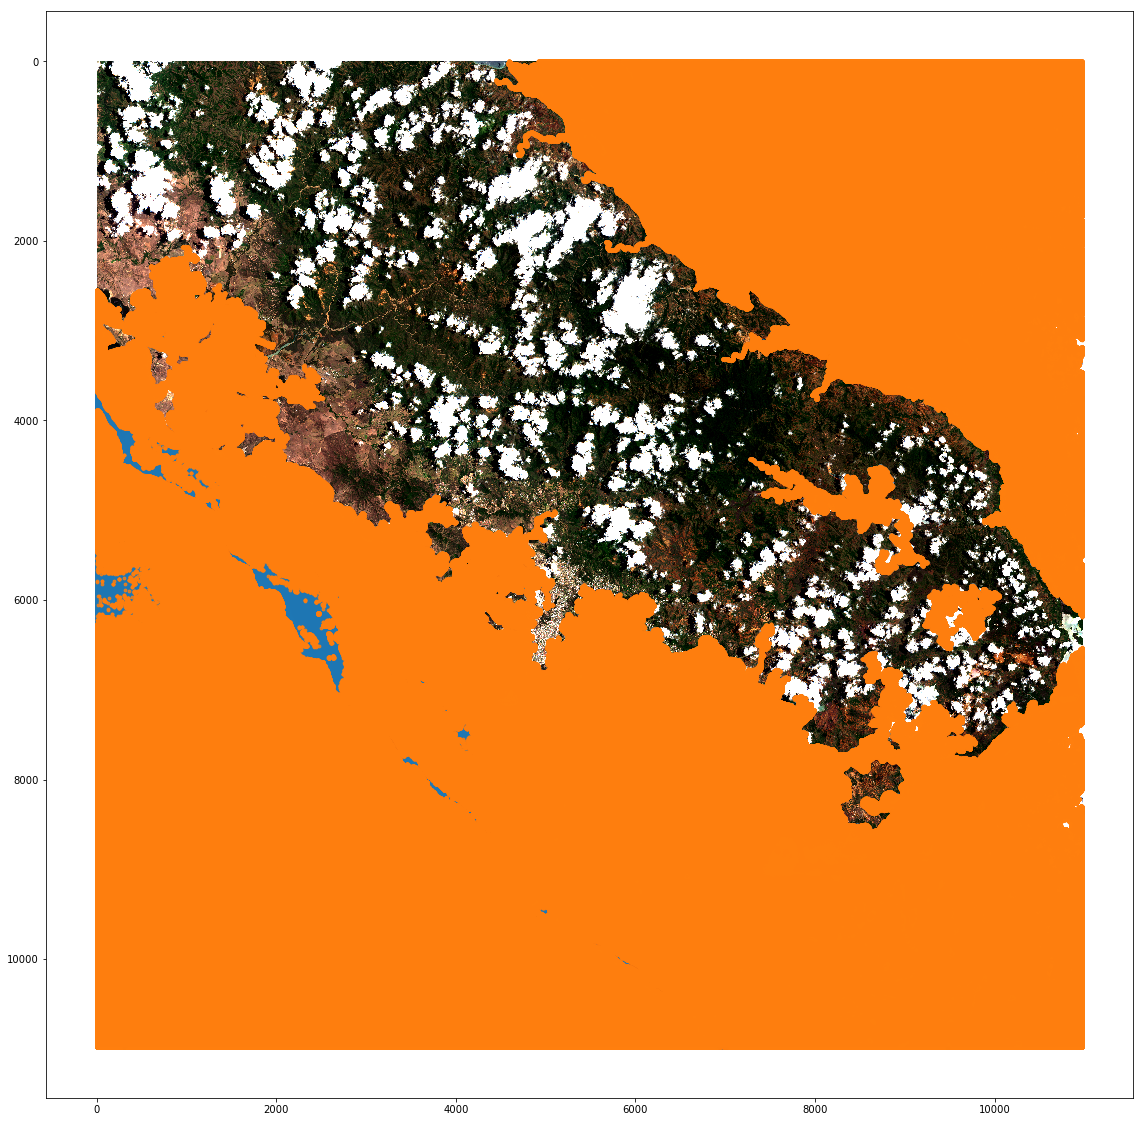

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.imshow(img_as_float(better_contrast))
row, column = np.where(SoilIndex==0)
for i in np.unique(y):
    index = y==i
    ax.scatter(column[index],row[index],alpha=0.8, s=8)



In [26]:
np.where(SoilIndex==0)

(array([    0,     0,     0, ..., 10979, 10979, 10979], dtype=int64),
 array([ 4587,  4588,  4589, ..., 10977, 10978, 10979], dtype=int64))

In [ ]:
output_fname = "classification.tiff"
train_data_path = "C:/Users/samrari/ComputBuffer/Classif/Classif_Eclatee/"
validation_data_path = "data/train/"

In [ ]:
%whos